# Introdução

O estudo dos métodos de interpretabilidade será feito com a base de dados de churn de cartão de crédito. No momento, passos de análise descritiva, construção, seleção e transformação de variáveis, calibração e distribuição das probabilidades serão pulados.

# Pacotes

In [20]:
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, brier_score_loss
from lime.lime_tabular import LimeTabularExplainer

# Conjunto de dados

In [4]:
zf = zipfile.ZipFile('/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/0.Base/credit-card-customers.zip') 
dados = pd.read_csv(zf.open('BankChurners.csv'))
dados = dados.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)
dados.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
# Volumetria: linhas e colunas

dados.shape

(10127, 21)

In [4]:
# Duplicidade

dados.duplicated().sum()

np.int64(0)

In [6]:
# Sem dados nulos

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [11]:
# Variável resposta

dados['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [13]:
# Percentual da variável target

dados['Attrition_Flag'].value_counts()/dados.shape[0]*100

Attrition_Flag
Existing Customer    83.934038
Attrited Customer    16.065962
Name: count, dtype: float64

In [5]:
# Por simplicidade considerar algumas variáveis: Total_Revolving_Bal, Total_Ct_Chng_Q4_Q1, Total_Relationship_Count, Months_Inactive_12_mon e Gender

colunas = ['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Gender', 'Attrition_Flag']
dados_filtrados = dados[colunas]

In [6]:
# Transformação da variável target e sexo em 0 - 1

mapa_churn = {
    'Existing Customer': 0,
    'Attrited Customer': 1
}

mapa_gender = {
    'M': 0,
    'F': 1
}

dados_filtrados.loc[:,'Attrition_Flag'] = dados_filtrados['Attrition_Flag'].map(mapa_churn)
dados_filtrados.loc[:,'Gender'] = dados_filtrados['Gender'].map(mapa_gender)

In [11]:
dados_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Total_Revolving_Bal       10127 non-null  int64  
 1   Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 2   Total_Relationship_Count  10127 non-null  int64  
 3   Months_Inactive_12_mon    10127 non-null  int64  
 4   Gender                    10127 non-null  object 
 5   Attrition_Flag            10127 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 474.8+ KB


In [7]:
# Converte os dados de objeto para inteiros

dados_filtrados['Gender'] = dados_filtrados['Gender'].astype('int')
dados_filtrados['Attrition_Flag'] = dados_filtrados['Attrition_Flag'].astype('int')

/tmp/ipykernel_26915/1034066381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['Gender'] = dados_filtrados['Gender'].astype('int')
/tmp/ipykernel_26915/1034066381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['Attrition_Flag'] = dados_filtrados['Attrition_Flag'].astype('int')


In [13]:
dados_filtrados.dtypes

Total_Revolving_Bal           int64
Total_Ct_Chng_Q4_Q1         float64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Gender                        int64
Attrition_Flag                int64
dtype: object

In [14]:
# Validação

dados_filtrados['Attrition_Flag'].value_counts()

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64

In [15]:
# Presença de dados duplicados

dados_filtrados.duplicated().sum()

np.int64(205)

In [8]:
# Remove os dados duplicados

dados_filtrados = dados_filtrados.drop_duplicates()

In [9]:
# Variáveis explicativas e resposta

X = dados_filtrados.drop(['Attrition_Flag'], axis = 1)
y = dados_filtrados['Attrition_Flag']

In [10]:
# Divisão da base em treino, validação e teste

# 80% para treino e 20% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=.20, stratify=y, random_state=1234)

# Dos 80% -> 90% para treino e 10% para validação
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=.10, stratify=y_treino, random_state=1234)

# Modelos

## Gradient Boosting

In [11]:
# https://scikit-learn.org/1.6/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

GBC = GradientBoostingClassifier(n_estimators=50, 
                                 learning_rate=0.05,
                                 max_depth=5,
                                 random_state=123)
GBC.fit(X_treino, y_treino)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
                           random_state=123)

In [12]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=GBC.predict_proba(X_treino)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=GBC.predict_proba(X_treino)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))
print("Precisão:", precision_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))
print("Recall:", recall_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.7608824819830008
Brier-score: 0.07053511600602985
F1-score: 0.6378923766816144
Precisão: 0.8454680534918276
Recall: 0.5121512151215122


In [13]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=GBC.predict_proba(X_val)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=GBC.predict_proba(X_val)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=GBC.predict(X_val)))
print("Precisão:", precision_score(y_true=y_val, y_pred=GBC.predict(X_val)))
print("Recall:", recall_score(y_true=y_val, y_pred=GBC.predict(X_val)))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.7404162274746765
Brier-score: 0.07192687675230944
F1-score: 0.6185567010309279
Precisão: 0.8450704225352113
Recall: 0.4878048780487805


## Regressão Logística

- http://leg.ufpr.br/~lucambio/ADC/ADC02.html#2.2
- https://lume.ufrgs.br/bitstream/handle/10183/128182/000522716.pdf?sequence=1
- http://courses.atlas.illinois.edu/fall2016/STAT/STAT200/RProgramming/LogisticRegression.html#:~:text=The%20residual%20deviance%20is%20the,to%20the%20average%20of%20y.
- https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.pseudo_rsquared.html

In [14]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html
glm_binom = sm.GLM(y_treino, X_treino, family=sm.families.Binomial())
GLM = glm_binom.fit()

In [34]:
GLM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         Attrition_Flag   No. Observations:                 7143
Model:                            GLM   Df Residuals:                     7138
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2424.6
Date:                Tue, 28 Jan 2025   Deviance:                       4849.2
Time:                        09:54:10   Pearson chi2:                 8.23e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1693
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Total_Revolving_Bal         -0.0008   4.59e-05    -16.911      0.000      -0.001      -0.001
Total_Ct_Chng_Q4_Q1         -3.3011      0.155    -21.283      0.000      -3.605      -2.997
Total_Relationship_Count    -0.1533      0.021     -7.207      0.000      -0.195      -0.112
Months_Inactive_12_mon       0.6015      0.032     18.943      0.000       0.539       0.664
Gender                       0.3853      0.074      5.228      0.000       0.241       0.530
============================================================================================
"""

In [15]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=GLM.predict(X_treino)))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=GLM.predict(X_treino)))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))
print("Precisão:", precision_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))
print("Recall:", recall_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.517288756353109
Brier-score: 0.10162672121896531
F1-score: 0.3170559094125973
Precisão: 0.7417218543046358
Recall: 0.20162016201620162


In [16]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=GLM.predict(X_val)))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=GLM.predict(X_val)))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))
print("Precisão:", precision_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))
print("Recall:", recall_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.5883022960446321
Brier-score: 0.09525439492151609
F1-score: 0.38271604938271603
Precisão: 0.7948717948717948
Recall: 0.25203252032520324


# Árvore de decisão

In [17]:
DT = DecisionTreeClassifier(max_depth=5)
DT.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=5)

In [18]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=DT.predict_proba(X_treino)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=DT.predict_proba(X_treino)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=DT.predict(X_treino)))
print("Precisão:", precision_score(y_true=y_treino, y_pred=DT.predict(X_treino)))
print("Recall:", recall_score(y_true=y_treino, y_pred=DT.predict(X_treino)))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.6588409533508888
Brier-score: 0.08017254293967364
F1-score: 0.6045049764274489
Precisão: 0.7230576441102757
Recall: 0.5193519351935193


In [19]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=DT.predict_proba(X_val)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=DT.predict_proba(X_val)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=DT.predict(X_val)))
print("Precisão:", precision_score(y_true=y_val, y_pred=DT.predict(X_val)))
print("Recall:", recall_score(y_true=y_val, y_pred=DT.predict(X_val)))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.6485741503101365
Brier-score: 0.07957955247964338
F1-score: 0.625
Precisão: 0.7647058823529411
Recall: 0.5284552845528455


# Interpretabilidade

## PDP (Partial Dependence Plot) e ICE Plot (Individual Conditional Expectation)

O gráfico de dependência parcial é um método agnóstico, com uma representação visual do comportamento médio do valor de uma variável, sem alterar os valores das demais variáveis, no modelo $\hat{f}(X)$. Seja $S$ o conjunto das variáveis que se deseja verificar o comportamento e $C$ o conjunto das variáveis restantes. A função de dependência parcial é:

$$
\hat{f}_{S}(x_{s}) = E_{X_{C}}[\hat{f}_{S}(x_{s},X_{C})] = \int \hat{f}_{S}(x_{s},X_{C})d\mathbb{P}(X_{C}).
$$

Ou seja, a marginalização ou isolamento da função estimada em um ponto ($x_{s}$) em relação aos demais valores das variáveis ($x_{c}$). 

O ICE plot mostra como as predições para cada instância ($\hat{f}$) mudam com a mudança dos valores da própria feature.

In [61]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import matplotlib.pyplot as plt

Abaixo, temos o gráfico de dependência parcial (PDP) para total de crédito rotativo no cartão de crédito (Total_Revoling_Bal), mudança de quantidade de transações no quarto e primeiro trimestre (Total_Ct_Chng_Q4_Q1) e as curvas de nível para a relação das duas variáveis.

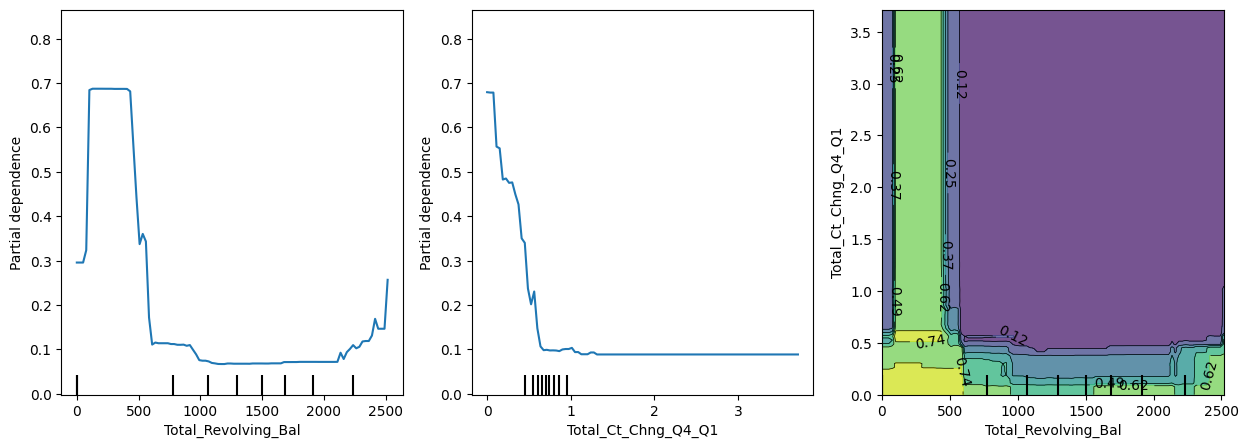

In [118]:
features = [0, 1, (0, 1)]
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='average',
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

Abaixo, temos os gráficos de dependência parcial para cada observação (ICE plot) e o valor médio em vermelho, que representa o PDP da variável de interesse.

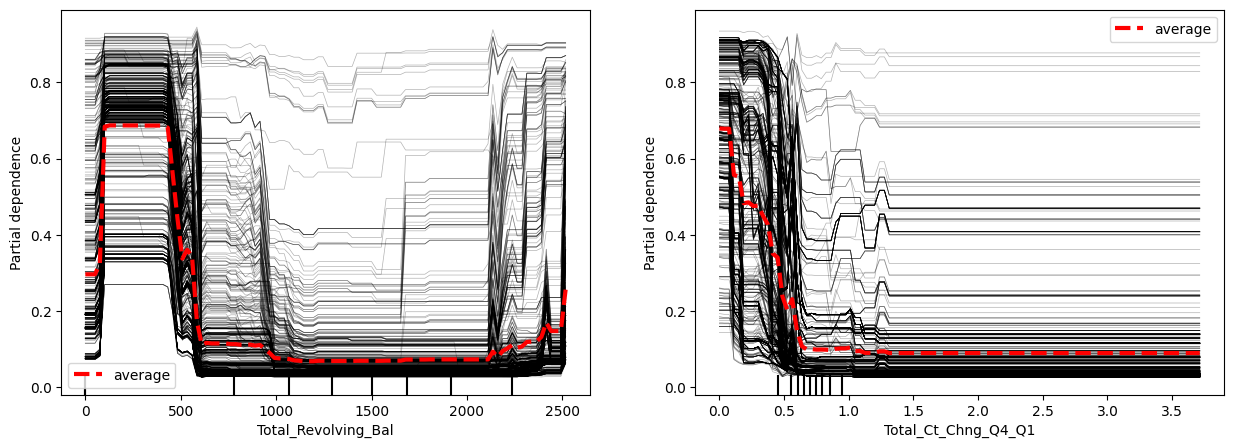

In [124]:
features = [0, 1]
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='both',
                                        ice_lines_kw={'color': 'black'},
                                        pd_line_kw={'color': 'red', 'lw': 3, 'linestyle': '--'},
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

Uma versão mais arrumada do gráfico acima é centralizar as curvas individuais em relação ao valor médio (linha vermelha). Dessa forma, cada ponto da curva preta é subtraída da curva vermelha. 

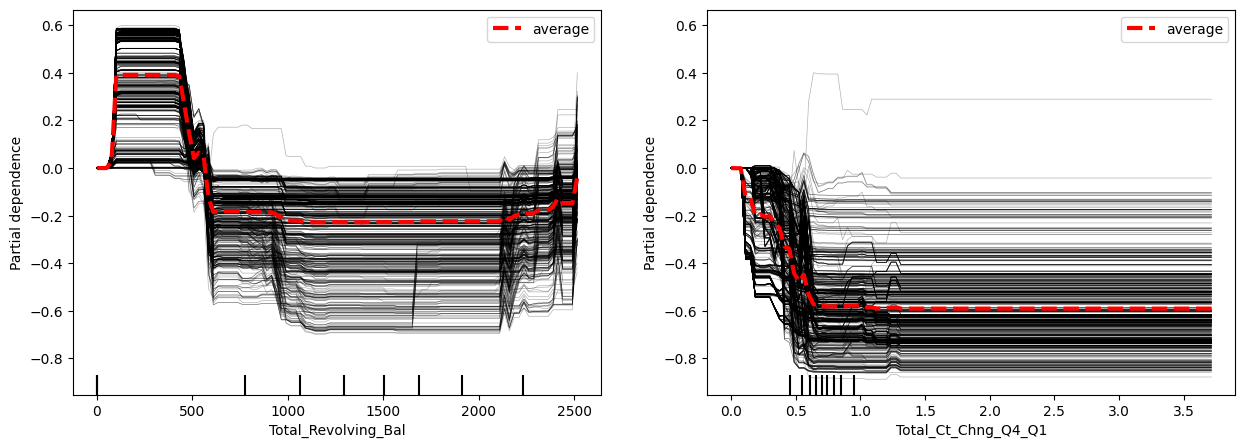

In [125]:
features = [0, 1]
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='both',
                                        centered=True,
                                        ice_lines_kw={'color': 'black'},
                                        pd_line_kw={'color': 'red', 'lw': 3, 'linestyle': '--'},
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

### Vantagens

- Fácil implementação e de entender

- O gráfico PODE apresentar uma relação exata entre o modelo e a variável explicativa, desde que esta última não esteja correlacionada com outras

- Captura relações positivas, negativas, não lineares e nenhum relacionamento entre com a variável resposta

### Desvantagens

- Assume intependência das variáveis

- Não é possível ver a interação entre duas variáveis

- Se uma variável tem metade dos valores com relação positiva e outra metade negativa, o efeito real da variável não pode ser avaliado. Isso gera uma linha horizontal.

- Pode gerar combinações de variáveis pouco prováveis de acontecer

## LIME (Local Interpretable Model-Agnostic Explanations)

LIME é um método agnóstico que nos ajuda a entender o porque o modelo direcionou para o resultado $\hat{f}$, para um indivíduo. A ideia é usar um modelo substitudo (surrogate model) mais simples em uma proximidade da observação que se deseja estudar, em geral um modelos linear ou até mesmo uma árvore de decisão simples, para entender quais variáveis impactam mais na predição, mas não a magnitude do impacto de fato no caso do modelo linear.

Resumidamente, a aproximação e interpretação local de um ponto é obtida pela otimização da equação:

$$
\xi(x) = argmin_{g \in G} L(f,g,K_{x}) + \Omega(g),
$$
$$
L(f,g,\pi_{x}) = \sum_{z, z' \in Z} K_{x}(z)(f(z) - g(z'))².
$$

$G$ é a família de modelos interpretáveis. Em geral, modelos lineares esparços;
$L$ é a função de perda entre o modelo interpretável e o modelo complexo;
$K$ é um kernel que estabelece a proximidade do ponto de interesse em relação aos demais pontos vizinhos;
$f$ é o modelo complexo;
$g$ é o modelo substituto interpretável;
$\Omega$ é uma técnica de regularização para que o modelo $g$ seja o mais simples possível (uso do Lasso, Ridge ou ElasticNet).


Passos para o algoritmo do LIME:

1. Selecionar a observação que queremos explicar. Representado pelo ponto preto, na figura abaixo;
2. Gere observações com base nas informações de treino. Essa amostra é gerada em todo o espaço das variáveis. Representado pelos "x", na figura abaixo;
    - As amostras são geradas com o uso de uma distribuição normal para as variáveis contínuas $X$~$N(\mu,\sigma ^2)$ e a distribuição multinomial para as variáveis categóricas com $p_{j} = \frac{n_{j}}{n}$, com $n_{j} :=$ número de vezes que a categoria $j$ aparece.
3. Coloque um peso para cada observação. Queremos entender o comportamento do modelo substituto ao redor da observação que queremos explicar;
    - Para isso usa-se um kernel gaussiano: $K(x,x') = \exp(\frac{||x -x'||_{2} ^2}{\sigma ^2})$. Se aumentarmos muito $\sigma ^2$ consideraremos mais observações distantes do ponto de interesse e se diminuirmos muito, poucas observações estarão para explicar aquele ponto.
    - $\sigma ^2 = 0.75 * \sqrt{(\#vars)}$, $\#vars$ é a quantidade de variáveis.
4. Realize as predições para as observações geradas e obtenha a target estimada;
5. Treine o modelo com a amostra gerada;
    - Para o treino do modelo as variáveis numéricas são discretizadas, geralmente, em decis.
6. Interpretação do modelo substituto.

<div>
<img src="Ex1.png" width="600"/>
</div>

In [108]:
explainer = LimeTabularExplainer(X_treino.values,
                                 feature_names = X_treino.columns,
                                 class_names = ['Attrition_Flag'],
                                 mode = 'classification', 
                                 random_state = 123)

In [109]:
y_treino[0]

np.int64(0)

In [113]:
GBC.predict_proba(X_treino)[0]

array([0.95889385, 0.04110615])

As barras e cores azuis representam impacto negativo e as barras e cores laranjas representam impacto positivo. 

In [141]:
exp = explainer.explain_instance(X_treino.iloc[0],
                                 GBC.predict_proba,
                                 num_features = 10)
exp.show_in_notebook(show_table = True)

/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

In [144]:
#fig = exp.as_pyplot_figure()
#plt.tight_layout()
#plt.show()

In [129]:
#pd.DataFrame(GBC.predict_proba(X_treino)[:,1])[pd.DataFrame(GBC.predict_proba(X_treino)[:,1])>.8].dropna()

In [131]:
y_treino.iloc[16]

np.int64(1)

In [132]:
GBC.predict_proba(X_treino)[16]

array([0.15124364, 0.84875636])

In [128]:
exp = explainer.explain_instance(X_treino.iloc[16],
                                 GBC.predict_proba,
                                 num_features = 10)

exp.show_in_notebook(show_table = True)

/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 